## Collaborative Recommender 
based on user behaviour 

**** https://www.kaggle.com/zolboo/recommender-systems-knn-svd-nn-keras/notebook

Use implicit package for python
https://implicit.readthedocs.io/en/latest/models.html

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

In [239]:
df1 = pd.read_csv('data/users_projects_0-100.csv')
df2 = pd.read_csv('data/users_projects_100-300.csv')
df3 = pd.read_csv('data/users_projects_300-500.csv')
df4 = pd.read_csv('data/users_projects_500-700.csv')
df5 = pd.read_csv('data/users_projects_700-900.csv')
df6 = pd.read_csv('data/users_projects_900-1100.csv')
df7 = pd.read_csv('data/users_projects_1100-1300.csv')
df8 = pd.read_csv('data/users_projects_1300-1500.csv')
df9 = pd.read_csv('data/users_projects_1500-1700.csv')# this one will need to be redone
df10 = pd.read_csv('data/users_projects_1700-1900.csv')
df11 = pd.read_csv('data/users_projects_1887-1900.csv')
df12 = pd.read_csv('data/users_projects_1900-2100.csv')
df13 = pd.read_csv('data/users_projects_2100-2300.csv')
df14 = pd.read_csv('data/users_projects_2300-2500.csv')
df15 = pd.read_csv('data/users_projects_2500-2700.csv')
df16 = pd.read_csv('data/users_projects_2700-2900.csv')
df17 = pd.read_csv('data/users_projects_2900-2962.csv')

pattern_details = pd.read_csv('data/consolidated_patterns.csv', low_memory=False)
# this needs to be repaced with cleaned data?

In [240]:
(df1.shape, df2.shape, df3.shape, df4.shape, 
 df5.shape, df6.shape, df7.shape, df8.shape,
 df9.shape, df10.shape, df11.shape,df12.shape,
 df13.shape, df14.shape, df15.shape,df16.shape, df17.shape
)

((343032, 4),
 (386356, 4),
 (248913, 4),
 (210382, 4),
 (171374, 4),
 (161808, 4),
 (281092, 4),
 (279575, 4),
 (596740, 4),
 (813227, 4),
 (35527, 4),
 (366425, 4),
 (298682, 4),
 (252212, 4),
 (220635, 4),
 (185410, 4),
 (44375, 4))

In [241]:
# For full set
df = df1.append(df2, ignore_index=True)
df = df.append(df3, ignore_index=True)
df = df.append(df4, ignore_index=True)
df = df.append(df5, ignore_index=True)
df = df.append(df6, ignore_index=True)
df = df.append(df7, ignore_index=True)
df = df.append(df8, ignore_index=True)
df = df.append(df9, ignore_index=True)
df = df.append(df10, ignore_index=True)
df = df.append(df11, ignore_index=True)
df = df.append(df12, ignore_index=True)
df = df.append(df13, ignore_index=True)
df = df.append(df14, ignore_index=True)
df = df.append(df15, ignore_index=True)
df = df.append(df16, ignore_index=True)
df = df.append(df17, ignore_index=True)
df.shape

(4895765, 4)

In [ ]:
# # use these plots from https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b
# # Number of ratings per user
# data = df.groupby('userID')['bookRating'].count().clip(upper=50)

# # Create trace
# trace = go.Histogram(x = data.values,
#                      name = 'Ratings',
#                      xbins = dict(start = 0,
#                                   end = 50,
#                                   size = 2))
# # Create layout
# layout = go.Layout(title = 'Distribution Of Number of Ratings Per User (Clipped at 50)',
#                    xaxis = dict(title = 'Ratings Per User'),
#                    yaxis = dict(title = 'Count'),
#                    bargap = 0.2)

# # Create plot
# fig = go.Figure(data=[trace], layout=layout)
# iplot(fig)

In [242]:
# Clean data and save

# remove accidental headers
df = df.drop(df[df['user_id']=='user_id'].index)

# remove douplicates
df = df.drop_duplicates()

# reset index
df.reset_index(inplace=True, drop=True)

# df.to_csv('data/user_projects_cleaned.csv', index=False)

In [243]:
df.shape

(4478010, 4)

In [244]:
# add 'has_knit' column is place of rating (using implicit rather than explicit rating)
df['has_knit'] = 1
print(df.shape)
df.head()

# rename uid and iid as per utility matrix

(4478010, 5)


,user_id,pattern_ids,date_completed,project_id,has_knit
0,5153610,88,2021/11/19,29203938,1
1,3183664,88,2021/11/18,29195691,1
2,3183664,88,2021/11/17,29190583,1
3,2102666,88,2021/11/17,29177512,1
4,3183664,88,2021/11/16,29187197,1


In [262]:
# drop douplicate knits per pattern
df = df.drop_duplicates(['user_id', 'pattern_ids'])
df.shape

(3250978, 5)

In [263]:
# how many users, how many patterns?
pattern_count_per_user = df.groupby("user_id", as_index=False).count().sort_values('has_knit', ascending = False)
pattern_count_per_user

# uh oh - how many are 0?


,user_id,pattern_ids,date_completed,project_id,has_knit
61820,17244,302,298,302,302
273983,698879,261,254,261,261
253153,616629,260,258,260,260
296299,79380,256,105,256,256
111658,24654,239,229,239,239
...,...,...,...,...,...
254489,6218491,1,1,1,1
254488,6218465,1,1,1,1
160108,342361,1,0,1,1
85382,204944,1,1,1,1


In [246]:
pattern_count_per_user.describe()

,pattern_ids,date_completed,project_id,has_knit
count,345059.000000,345059.000000,345059.000000,345059.000000
mean,12.977520,10.615164,12.977520,12.977520
std,22.736905,21.070589,22.736905,22.736905
min,1.000000,0.000000,1.000000,1.000000
25%,2.000000,1.000000,2.000000,2.000000
50%,4.000000,3.000000,4.000000,4.000000
75%,14.000000,11.000000,14.000000,14.000000
max,720.000000,720.000000,720.000000,720.000000


In [ ]:
# AND LOOK AT THIS  _ ALSO FROM WALKTHROUGH!
# # from article - ensure statiscical significance, users less than 200 ratings and books less than 100 ratings excluede
# counts1 = book_ratings['User-ID'].value_counts()
# book_ratings = book_ratings[book_ratings['User-ID'].isin(counts1[counts1 >= 200].index)]
# counts = book_ratings['Book-Rating'].value_counts()
# book_ratings = book_ratings[book_ratings['Book-Rating'].isin(counts[counts >= 100].index)]

In [ ]:
# # OR TRY THIS FROM MEMORY WALKTRHOUGH 
# import matplotlib.pyplot as plt
# print(book_ratings.shape)
# print(list(book_ratings.columns))
# plt.rc("font", size=15)
# book_ratings['Book-Rating'].value_counts(sort=False).plot(kind='bar')
# plt.title('Rating Distribution\n')
# plt.xlabel('Rating')
# plt.ylabel('Count')
# plt.savefig('system1.png', bbox_inches='tight')
# plt.show()
# print(books.shape)
# print(list(books.columns))

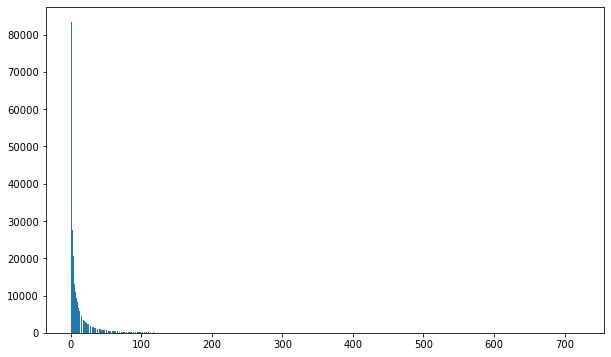

In [247]:
y = pattern_count_per_user['pattern_ids']
fig, ax = plt.subplots(figsize = (10,6))

# histogram
ax.hist(y,bins=1000)
plt.show()

In [266]:
pattern_count_per_user_gt_40 = pattern_count_per_user[pattern_count_per_user['pattern_ids'] >40]
# pattern_count_per_user.shape
indices_to_drop = pattern_count_per_user[pattern_count_per_user['pattern_ids'] <=40].index.to_list()
len(indices_to_drop)

323603

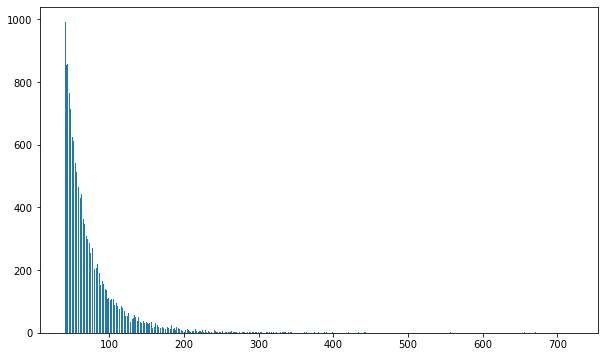

In [256]:
y = pattern_count_per_user_gt_40['pattern_ids']
fig, ax = plt.subplots(figsize = (10,6))

# histogram
ax.hist(y,bins=1000)
plt.show()

In [257]:

df = df[~df.index.isin(indices_to_drop)]
# merge metadata
df.shape

(3250978, 5)

In [265]:
pattern_count_per_user_gt_40.describe()

,pattern_ids,date_completed,project_id,has_knit
count,27661.000000,27661.000000,27661.000000,27661.000000
mean,73.736416,65.853368,73.736416,73.736416
std,39.116392,38.951095,39.116392,39.116392
min,41.000000,0.000000,41.000000,41.000000
25%,49.000000,43.000000,49.000000,49.000000
50%,61.000000,55.000000,61.000000,61.000000
75%,84.000000,77.000000,84.000000,84.000000
max,720.000000,720.000000,720.000000,720.000000


In [258]:
df.pattern_ids.values

array(['88', '88', '88', ..., '449489', '449489', '449489'], dtype=object)

In [260]:
# In order to pull out pattern details after we get similar patterns, need the metadata 
#(merge df with pattern_details)

metadata = pattern_details[pattern_details['pattern_id'].isin(df.pattern_ids.values)]
# REINDEX??
print(metadata.shape)
metadata.head()

(2963, 24)


,pattern_id,name,name_permalink,favorites_count,projects_count,difficulty_average,difficulty_count,rating_average,queued_projects_count,rating_count,...,pattern_attributes,yardage_max,yardage,generally_available,gauge,gauge_divisor,free,downloadable,categories,yarn_weight_description
0,88,Calorimetry,calorimetry,29838,19426,1.816424,7294.0,4.225295,7895,6618.0,...,"['unisex', 'teen', 'adult', 'fitted', 'reversi...",NaN,93.0,2006/12/01 00:00:00 -0500,20.0,4.0,True,True,"['headband', 'headwear', 'accessories']",Aran (8 wpi)
1,3156,Basic Ribbed Socks,basic-ribbed-socks,17795,10987,2.435581,2670.0,4.455242,3519,2480.0,...,"['unisex', 'adult', 'top-cuff-down', 'heel-fla...",NaN,370.0,2006/04/01 00:00:00 -0500,32.0,4.0,True,True,"['mid-calf', 'socks', 'feet-legs', 'accessories']",Fingering (14 wpi)
2,3636,"#29 Classic Socks- baby, child & adult socks",29-classic-socks--baby-child--adult-socks,3483,6019,2.851249,921.0,4.493304,463,896.0,...,"['unisex', 'baby', 'toddler', 'child', 'teen',...",NaN,NaN,2007/05/18 07:01:30 -0400,NaN,1.0,False,True,"['mid-calf', 'socks', 'feet-legs', 'accessories']",Sport (12 wpi)
3,27077,Jacques Cousteau Hat,jacques-cousteau-hat,22539,7325,1.865684,2442.0,4.267587,4534,2246.0,...,"['male', 'ribbed', 'written-pattern', 'in-the-...",234.0,234.0,2006/03/01 00:00:00 -0500,22.0,4.0,True,True,"['beanie-toque', 'hat', 'accessories']",DK (11 wpi)
4,29869,Sock Patterns for Regia 4ply,sock-patterns-for-regia-4ply,1190,2469,2.853333,300.0,4.223776,219,286.0,...,"['unisex', 'adult', 'top-cuff-down', 'heel-fla...",NaN,460.0,2007/10/27 18:20:38 -0400,30.0,4.0,False,False,"['mid-calf', 'socks', 'feet-legs', 'accessories']",Fingering (14 wpi)


#### Check Sparsity

In [314]:
n_users = df.user_id.unique().shape[0]
n_items = df.pattern_ids.unique().shape[0]

print('Number of users: {}'.format(n_users))
print('Number of models: {}'.format(n_items))
print('Sparsity: {:4.3f}%'.format(float(df.shape[0]) / float(n_users*n_items) * 100))

# Woot - this is above the 0.1 percent threshold - performance generally degrades the more sparse the matrix is 

Number of users: 338751
Number of models: 2961
Sparsity: 0.324%


### Unique counts

In [ ]:
# print('No. of Unique Users    :', reviews.userID.nunique())
# print('No. of Unique Business :', reviews.businessID.nunique())
# print('No. of Unique Ratings  :', reviews.rating.nunique())


# look here for bar charts I should include here too
# https://bmanohar16.github.io/blog/recsys-evaluation-in-surprise

In [315]:
df.shape

(3250978, 5)

In [68]:
# user_project_map = df.pivot_table(index='user_id', columns='pattern_ids', values='has_knit')
# user_project_map.head()                    
# user_project_map.shape
# # user_project_map.head()

(290270, 1700)

In [385]:
df.to_csv('data/less_sparse_users_patterns.csv', index=False)

### K-Nearest Neighbours

#### TODO - try different metrics (Euclidean, cosine, pearson, jaccard)

In [326]:
from scipy.sparse import csr_matrix
user_knit = df
user_knit = user_knit.drop_duplicates(['user_id', 'pattern_ids'])
user_knit_pivot = user_knit.pivot(index='pattern_ids', columns='user_id', values='has_knit').fillna(0)
user_knit_matrix = csr_matrix(user_knit_pivot.values)


(2961, 338751)

In [327]:
user_knit_pivot.shape, user_knit_matrix.shape

((2961, 338751), (2961, 338751))

In [276]:
# from sklearn.neighbors import NearestNeighbors
# https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm (to see which algorithm to use)
# # ‘ball_tree’ will use BallTree
# ‘kd_tree’ will use KDTree
# ‘brute’ will use a brute-force search.
# ‘auto’ will attempt to decide the most appropriate algorithm based on the values passed to fit method.

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')  # default default=’minkowski’ (real value space) - try “jaccard” (boolean vector space)
model_knn.fit(user_knit_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [282]:
# give recommendation - need to reference this article!! 
query_index = np.random.choice(user_knit_pivot.shape[0])
print(query_index)
distances, indices = model_knn.kneighbors(user_knit_pivot.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 10)

363


In [280]:
# user_knit_pivot.index[0] - 0 is the indexlocation

'10'

In [278]:
# user_knit_pivot.index[query_index] - this is the pattern id

'66726'

In [ ]:
# TODO turn into one function! pattern id to name! 

def get_index_from_pattern_id(pattern_id):
    return metadata[metadata.pattern_id == pattern_id].index[0]

pattern_id = int(user_knit_pivot.index[query_index])
pattern_index = get_index_from_pattern_id(pattern_id)

def get_pattern_name_from_index(pattern_index):
    return metadata[metadata.index == pattern_index]["name_permalink"].values[0]

In [311]:
# give recomendations for the pattern selected
for i in range(0, len(distances.flatten())):
    if i == 0:
#         print('Recommendations for {0} :\n'.format(user_knit_pivot.index[query_index]))
        print('Recommendations for {0} :\n'.format(get_pattern_name_from_index(get_index_from_pattern_id(int(user_knit_pivot.index[query_index])))))
    else:
        pattern_id = int(user_knit_pivot.index[indices.flatten()[i]])
        pattern_metadata_index = get_index_from_pattern_id(pattern_id)
        pattern_name = get_pattern_name_from_index(pattern_metadata_index)
 
        print('{0}: {1} {2}, with distance of {3}:'
                .format(i, pattern_id, pattern_name, distances.flatten()[i]))
    

Recommendations for ballard-slouch-hat :

1: 68244 spring-beret, with distance of 0.9509073427788148:
2: 88047 meret-mystery-beret, with distance of 0.9560338047669551:
3: 39289 slouched-tuva-hat, with distance of 0.9637694432884212:
4: 169260 honey-cowl, with distance of 0.9643256479027382:
5: 75857 turn-a-square, with distance of 0.964634800369007:
6: 38821 felicity, with distance of 0.9655716179828302:
7: 103556 ishbel, with distance of 0.9668805982387101:
8: 97913 opus-spicatum, with distance of 0.967951950173751:
9: 494 slouchy-copy-cat-hat, with distance of 0.9682919743685515:


### Matrix factorization 

https://towardsdatascience.com/recommender-system-singular-value-decomposition-svd-truncated-svd-97096338f361
In Conclusion:
Singular value decomposition decomposes three matrices and the latent factors show the characteristics of the items. It reduces the dimension through latent factors’ extraction. By adding the regularization and bias term, it optimizes the model performance by minimizing the rmse error.
Truncated SVD generates the matrices with the specified number of columns, whereas SVD outputs n columns of matrices. It decreases the number of output and better works on the sparse matrices for features output.

In [191]:
# https://towardsdatascience.com/how-did-we-build-book-recommender-systems-in-an-hour-part-2-k-nearest-neighbors-and-matrix-c04b3c2ef55c

# ** will need to cross validate and include names! **
# ** use other metrics than pearson - use cosine? **
# import sklearn
from sklearn.decomposition import TruncatedSVD
# trucated reduces dimensionality to avoid running into erros

In [362]:
print(user_knit_pivot.shape)
# user_knit_pivot_2 = user_knit_pivot.T
user_knit_pivot.head()

(2961, 338751)


user_id,1,100,1000,10000027,1000008,1000012,1000016,100002,1000031,10000324,...,999942,9999542,999965,999976,999984,9999877,99999,999991,9999924,9999967
pattern_ids,,,,,,,,,,,,,,,,,,,,,
10,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1004424,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [370]:
X = user_knit_pivot.values
svd = TruncatedSVD(n_components=1000, random_state =88)
matrix = svd.fit_transform(X)
matrix.shape

(2961, 1000)

In [372]:
explained_variance_ratios = svd.explained_variance_ratio_
explained_variance_ratios_sum = svd.explained_variance_ratio_.sum()
singular_values = svd.singular_values_
print(explained_variance_ratios_sum )

0.6715038510348262


In [318]:
# calculate pearson R correlation 

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
corr = np.corrcoef(matrix)
corr.shape

(2961, 2961)

In [319]:
pattern_ids = user_knit_pivot.index
pattern_ids_list = list(pattern_ids)
# pattern_ids_list

In [320]:
pattern_100315 = pattern_ids_list.index('100315')

In [321]:
corr_100315 = corr[pattern_100315]

In [322]:
list(pattern_ids[(corr_100315<1.0)&(corr_100315>0.95)])

['135838',
 '142636',
 '146639',
 '146682',
 '149026',
 '157344',
 '169841',
 '172812',
 '175172',
 '196381',
 '200709',
 '203002',
 '203128',
 '206221',
 '213483',
 '256724',
 '268530',
 '268546',
 '290445',
 '368955',
 '58778',
 '64404']

In [ ]:
USE TRUNCATED SVD AND cross validation!! 

## Matrix Factorization using implicit library
https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/
https://towardsdatascience.com/alternating-least-square-for-implicit-dataset-with-code-8e7999277f4b

In [233]:
import pandas as pd
import numpy as np
import scipy.sparse as sparse
import random
# import implicit 

In [219]:
df_implicit = df[['user_id','pattern_ids']]
df_implicit.columns = ['uid', 'iid']
df_implicit.head()


,uid,iid
0,5153610,88
12,2187244,88
55,221081,88
92,193651,88
98,131434,88


In [217]:
print('Duplicated rows: ' + str(df_implicit.duplicated().sum()))
print('That\'s weird - let\'s just drop them')
df.drop_duplicates(inplace=True)

Duplicated rows: 507372
That's weird - let's just drop them


Number of users: 290270
Number of models: 1700
Sparsity: 0.486%


In [ ]:
# From reference above
# def threshold_likes(df, uid_min, mid_min):
#     n_users = df.uid.unique().shape[0]
#     n_items = df.mid.unique().shape[0]
#     sparsity = float(df.shape[0]) / float(n_users*n_items) * 100
#     print('Starting likes info')
#     print('Number of users: {}'.format(n_users))
#     print('Number of models: {}'.format(n_items))
#     print('Sparsity: {:4.3f}%'.format(sparsity))
    
#     done = False
#     while not done:
#         starting_shape = df.shape[0]
#         mid_counts = df.groupby('uid').mid.count()
#         df = df[~df.uid.isin(mid_counts[mid_counts < mid_min].index.tolist())]
#         uid_counts = df.groupby('mid').uid.count()
#         df = df[~df.mid.isin(uid_counts[uid_counts < uid_min].index.tolist())]
#         ending_shape = df.shape[0]
#         if starting_shape == ending_shape:
#             done = True
    
#     assert(df.groupby('uid').mid.count().min() >= mid_min)
#     assert(df.groupby('mid').uid.count().min() >= uid_min)
    
#     n_users = df.uid.unique().shape[0]
#     n_items = df.mid.unique().shape[0]
#     sparsity = float(df.shape[0]) / float(n_users*n_items) * 100
#     print('Ending likes info')
#     print('Number of users: {}'.format(n_users))
#     print('Number of models: {}'.format(n_items))
#     print('Sparsity: {:4.3f}%'.format(sparsity))
#     return df

In [225]:
# Create mappings - huh can't we do this with pivot?
iid_to_idx = {}
idx_to_iid = {}
for (idx, iid) in enumerate(df_implicit.iid.unique().tolist()):
    iid_to_idx[iid] = idx
    idx_to_iid[idx] = iid
    
uid_to_idx = {}
idx_to_uid = {}
for (idx, uid) in enumerate(df_implicit.uid.unique().tolist()):
    uid_to_idx[uid] = idx
    idx_to_uid[idx] = uid

In [226]:
def map_ids(row, mapper):
    return mapper[row]

In [234]:
%%timeit
I = df_implicit.uid.apply(map_ids, args=[uid_to_idx]).to_numpy()
J = df_implicit.iid.apply(map_ids, args=[iid_to_idx]).to_numpy()
V = np.ones(I.shape[0])
likes = sparse.coo_matrix((V, (I, J)), dtype=np.float64)
likes = likes.tocsr()

2.7 s ± 58.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [235]:
def train_test_split(ratings, split_count, fraction=None):
    """
    Split recommendation data into train and test sets
    
    Params
    ------
    ratings : scipy.sparse matrix
        Interactions between users and items.
    split_count : int
        Number of user-item-interactions per user to move
        from training to test set.
    fractions : float
        Fraction of users to split off some of their
        interactions into test set. If None, then all 
        users are considered.
    """
    # Note: likely not the fastest way to do things below.
    train = ratings.copy().tocoo()
    test = sparse.lil_matrix(train.shape)
    
    if fraction:
        try:
            user_index = np.random.choice(
                np.where(np.bincount(train.row) >= split_count * 2)[0], 
                replace=False,
                size=np.int32(np.floor(fraction * train.shape[0]))
            ).tolist()
        except:
            print(('Not enough users with > {} '
                  'interactions for fraction of {}')\
                  .format(2*k, fraction))
            raise
    else:
        user_index = range(train.shape[0])
        
    train = train.tolil()

    for user in user_index:
        test_ratings = np.random.choice(ratings.getrow(user).indices, 
                                        size=split_count, 
                                        replace=False)
        train[user, test_ratings] = 0.
        # These are just 1.0 right now
        test[user, test_ratings] = ratings[user, test_ratings]
   
    
    # Test and training are truly disjoint
    assert(train.multiply(test).nnz == 0)
    return train.tocsr(), test.tocsr(), user_index


In [351]:
# train, test, user_index = train_test_split(likes, 5, fraction=0.2)


In [350]:
# import implicit
# import scipy.sparse as sparse

# # initialize a model
# model = implicit.als.AlternatingLeastSquares(factors=50)

# # train the model on a sparse matrix of item/user/confidence weights
# model.fit(item_user_data)

# # recommend items for a user
# user_items = item_user_data.T.tocsr()
# recommendations = model.recommend(userid, user_items)

# # find related items
# related = model.similar_items(itemid)

In [ ]:
#suprise library 
can use knn compare cosine ve pearson_baseling
user_based = Fale

### Model Based (Matrix Factorization)

look at this one:
https://towardsdatascience.com/recommender-system-singular-value-decomposition-svd-truncated-svd-97096338f361

*** include TSNE FROM this one and split


uh oh - looks like surpise doesn't support implict rating??
https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVDpp this works though

#### lets try this one out 
https://analyticsindiamag.com/singular-value-decomposition-svd-application-recommender-system/

In [345]:
import pandas as pd

from surprise import SVD
from surprise import SVDpp

# # import dataset from surprise
from surprise import Dataset
from surprise import Reader

import surprise
# import random

# import accuracy from surprise
from surprise import accuracy

# import train_test_split from surprise.model_selection
from surprise.model_selection import train_test_split
# import GridSearchCV from surprise.model_selection
from surprise.model_selection import GridSearchCV
# import cross_validate from surprise.model_selection
from surprise.model_selection import cross_validate
from surprise.model_selection.split import PredefinedKFold#kFold 

In [337]:
df.head()
dataset = df[['user_id', 'pattern_ids', 'has_knit']]

In [338]:
reader = surprise.Reader(rating_scale = (0,1))
data = surprise.Dataset.load_from_df(dataset, reader)

In [339]:
trainset, testset = train_test_split(data, test_size=.2)

In [340]:
alg = SVD(verbose=True)
alg.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19


In [341]:
predictions = alg.test(testset)
accuracy.rmse(predictions)

RMSE: 0.0116


0.01156520893410513

In [342]:
param_grid = {'n_factors': [10, 50, 80], 'reg_all': [0.08, 0.1, 0.15]}

In [348]:
cv=PredefinedKFold()
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=cv)
gs.fit(trainset)  # this needs to be just trainset!
print(gs.best_params['rmse'])
print(gs.best_score['rmse'])


AttributeError: 'Trainset' object has no attribute 'folds_files'

In [93]:
# # Actually want truncated... better for memory 
# alg = surprise.SVDpp()
# output = alg.fit(data.build_full_trainset())

In [95]:
# # The uid and iid should be set as strings (uid - user_id, iid - item-id)
# pred = alg.predict(uid='11826', iid='374')
# score = pred.est
# print(score)

0.9999667910111882


In [ ]:
# # recommendations
# import difflib
# import random

# def get_book_id(book_title, metadata):
    
#     """
#     Gets the book ID for a book title based on the closest match in the metadata dataframe.
#     """
    
#     existing_titles = list(metadata['title'].values)
#     closest_titles = difflib.get_close_matches(book_title, existing_titles)
#     book_id = metadata[metadata['title'] == closest_titles[0]]['id'].values[0]
#     return book_id

# def get_book_info(book_id, metadata):
    
#     """
#     Returns some basic information about a book given the book id and the metadata dataframe.
#     """
    
#     book_info = metadata[metadata['id'] == book_id][['id', 'isbn', 
#                                                     'authors', 'title', 'original_title']]
#     return book_info.to_dict(orient='records')

# def predict_review(user_id, book_title, model, metadata):
    
#     """
#     Predicts the review (on a scale of 1-5) that a user would assign to a specific book. 
#     """
    
#     book_id = get_book_id(book_title, metadata)
#     review_prediction = model.predict(uid=user_id, iid=book_id)
#     return review_prediction.est

# def generate_recommendation(user_id, model, metadata, thresh=4):
    
#     """
#     Generates a book recommendation for a user based on a rating threshold. Only
#     books with a predicted rating at or above the threshold will be recommended
#     """
    
#     book_titles = list(metadata['title'].values)
#     random.shuffle(book_titles)
    
#     for book_title in book_titles:
#         rating = predict_review(user_id, book_title, model, metadata)
#         if rating >= thresh:
#             book_id = get_book_id(book_title, metadata)
#             return get_book_info(book_id, metadata)

## Using surprise
from https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b

In [335]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVDpp()]:
    # Perform cross validation
    cv = PredefinedKFold
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=1)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')    

KeyboardInterrupt: 

In [349]:
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

Using ALS


NameError: name 'BaselineOnly' is not defined

In [ ]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

### Try again this time with
https://towardsdatascience.com/svd-where-model-tuning-goes-wrong-61c269402919

In [356]:
from surprise import SVD,NormalPredictor
from surprise.model_selection import GridSearchCV
param_grid = {'n_factors':[50,100,150],'n_epochs':[20,30],  'lr_all':[0.005,0.01],'reg_all':[0.02,0.1]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs =-1)
gs.fit(data)

params = gs.best_params['rmse']
svdtuned = SVD(n_factors=params['n_factors'], n_epochs=params['n_epochs'], lr_all=params['lr_all'], reg_all=params['reg_all'])

TypeError: __init__() got an unexpected keyword argument 'verbose'

In [ ]:
steps = [('svd', TruncatedSVD(n_components=10)), ('m', LogisticRegression())]
model = Pipeline(steps=steps)
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

## Okay one more go with surprise
https://bmanohar16.github.io/blog/recsys-evaluation-in-surprise

In [374]:
# Imports
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore
from surprise import SVD, SVDpp, NMF
from surprise import SlopeOne, CoClustering

In [373]:
user_knit
user_pattern_utility = user_knit[['user_id', 'pattern_ids','has_knit']]

In [375]:
svd_cv = cross_validate(SVD(), data, cv=3, n_jobs=5, verbose=False)
# svdpp_cv = cross_validate(SVDpp(), data, cv=3, n_jobs=5, verbose=False)
# nmf_cv = cross_validate(NMF(), data, cv=3, n_jobs=5, verbose=False)

In [376]:
print('Algorithm\t RMSE\t\t MAE')
print('SVD', '\t\t', round(svd_cv['test_rmse'].mean(), 4), '\t', round(svd_cv['test_mae'].mean(), 4))
# print('SVDpp', '\t\t', round(svdpp_cv['test_rmse'].mean(), 4), '\t', round(svdpp_cv['test_mae'].mean(), 4))
# print('NMF', '\t\t', round(nmf_cv['test_rmse'].mean(), 4), '\t', round(nmf_cv['test_mae'].mean(), 4))


Algorithm	 RMSE		 MAE
SVD 		 0.0142 	 0.006


In [378]:
# Parameter space
svd_param_grid = {'n_epochs': [20, 25], 
                  'lr_all': [0.007, 0.009, 0.01],
                  'reg_all': [0.4, 0.6]}

# svdpp_gs = GridSearchCV(SVDpp, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
# svdpp_gs.fit(data)

svd_gs = GridSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=5)
svd_gs.fit(data)

In [380]:
# print('SVDpp - RMSE:', round(svdpp_gs.best_score['rmse'], 4), '; MAE:', round(svdpp_gs.best_score['mae'], 4))
print('SVD   - RMSE:', round(svd_gs.best_score['rmse'], 4), '; MAE:', round(svd_gs.best_score['mae'], 4))

SVD   - RMSE: 0.0 ; MAE: 0.0


In [ ]:
# print('RMSE =', svdpp_gs.best_params['rmse'])
# print('MAE =', svdpp_gs.best_params['mae'])

In [381]:
# RMSE = {'n_epochs': 25, 'lr_all': 0.007, 'reg_all': 0.4}
# MAE = {'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.4}

In [382]:
print('RMSE =', svd_gs.best_params['rmse'])
print('MAE =', svd_gs.best_params['mae'])

RMSE = {'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.6}
MAE = {'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.6}


In [ ]:
RMSE = {'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.6}
MAE = {'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.6}

In [ ]:
https://blog.cambridgespark.com/tutorial-practical-introduction-to-recommender-systems-dbe22848392b

** use this one !! in the end test train?